In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.insert(0, "../")

import builtins
builtins.NAMING = "new"


from plotting_src.header_settings import *
from plotting_src.read_ggp_run import * 
from simulations.cells_simulation import * 

from plotting_src.cells_utils import *
from plotting_src.read_utils import *


%config InlineBackend.figure_format ='retina'

header_setting.py: using new naming


In [2]:
def get_metas(prediction_files):
    prediction_files = sorted(prediction_files)
    samples = pd.DataFrame(index=prediction_files, columns=["date", "sample", "promoter", "condition", "replicate"])
    for pf in prediction_files:
        sample = "_".join(pf.split("/")[-1].split(".")[0].split("_")[:3])
        samples.loc[pf,"sample"] = sample
        samples.loc[pf,"condition"] = sample.split("_")[0]
        samples.loc[pf,"promoter"] = sample.split("_")[1]
        samples.loc[pf,"date"] = sample.split("_")[2]

    condition_promoter_tuples = []
    for pf in prediction_files:
        condition_promoter_tuple = "_".join(samples.loc[pf,"sample"].split("_")[:2])
        if condition_promoter_tuple in condition_promoter_tuples:
            samples.loc[pf,"replicate"] = "2"
        else:
            samples.loc[pf,"replicate"] = "1"
        condition_promoter_tuples.append(condition_promoter_tuple)

    return samples.to_dict('index')

def calc_log_concentration(cells):
    for i, cell in enumerate(cells):
        c = cell.gfp/np.exp(cell.log_length)
        if np.any(c<0):
            print(c)
        cells[i].log_concentration = np.log(c)
        cells[i].log1_concentration = np.log(c+1)
        cells[i].concentration = c
    return cells

def get_mean_growth_rate(cells):
    mean_lambda = np.sum(np.concatenate([np.array(cell.lt)/np.array(cell.cov_ll) for cell in cells])) \
                /np.sum(np.concatenate([1./np.array(cell.cov_ll) for cell in cells]))
    return mean_lambda

def get_integration_file(pf, setting):
    parent_dir = os.path.join(*pf.split("/")[:-1])
    sample = '_'.join(pf.split('/')[-1].split('_')[:3])
    return os.path.join(*parent_dir.split("/")[:-1], "integration",sample, setting, sample+"_"+setting+'.csv')

def get_cells(samples):
    for pf in samples.keys():
        samples[pf]["cells"] = calc_log_concentration(ggp_df2cells(read_ggp_csv(pf)))
        samples[pf]["mean_growth_rate"] = get_mean_growth_rate(samples[pf]["cells"])

    return samples

def filter_dict(samples, filter_key=None):
    new_samples = {}
    for pf in samples.keys():
        sample_name = pf.split("/")[-1].split("_")
        if filter_key in sample_name:
            new_samples[pf] = samples[pf]
    return new_samples

def filter_dict_not(samples, *filter_keys):
    new_samples = {}
    for pf in samples.keys():
        sample_name = pf.split("/")[-1].split("_")
        remove = np.any([filter_key in sample_name for filter_key in filter_keys])
        if not remove:
            new_samples[pf] = samples[pf]
    return new_samples

def get_replicate(samples, repl="1"):
    new_samples = {}
    for pf in samples.keys():
        
        if samples[pf]["replicate"] == repl :
            new_samples[pf] = samples[pf]
    return new_samples



In [3]:

        

input_dir =     "../../fluctuations_paper_data/mother_machine_data_sets/"
prediction_files = get_input_files(input_dir, keyword="prediction")

samples = get_metas(prediction_files)
samples = get_cells(samples)


first_replicates = filter_dict_not(get_replicate(samples), "6300") 


In [4]:
def get_lambda(cells):
    return np.concatenate([cell.lt for cell in cells])*60

def get_q(cells):
    return np.concatenate([cell.qt for cell in cells])*60

def get_qprime(cells):
    return np.concatenate([np.array(cell.qt)/np.array(cell.lt) for cell in cells])

def get_Q(cells):
    return np.concatenate([ np.array(cell.qt)*np.exp(cell.log_length) for cell in cells])*60

def get_v(cells):
    return np.concatenate([ np.exp(cell.log_length) for cell in cells])

def get_log_qprime(cells):
    qp = np.log(get_qprime(cells))
    return qp

def get_log_invlambda(cells):
    linv = 1./get_lambda(cells)
    return np.log(linv)

def get_log_lambda(cells):
    ll = get_lambda(cells)
    return np.log(ll)

###################
def get_corr_label(x,y):
    c = np.corrcoef(x,y)[0,1]
    return "R={:.3f}".format(c)

###################
color_cmaps = ["Greens", "Greens", "Reds", "Reds", "YlOrBr", "YlOrBr"]

cmap_by_promoter = {k: col for k,col  in zip(promoters, color_cmaps)}


In [5]:


def get_finite_tuple(cells, log=True):
    if log:
        ll = get_log_lambda(cells)
        qp = get_log_qprime(cells)
    else:
        ll = get_lambda(cells)
        qp = get_qprime(cells)
        
    x = np.isfinite(qp*ll)
    return ll[x], qp[x]

/Users/bjoern/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in log
/Users/bjoern/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in log
  app.launch_new_instance()


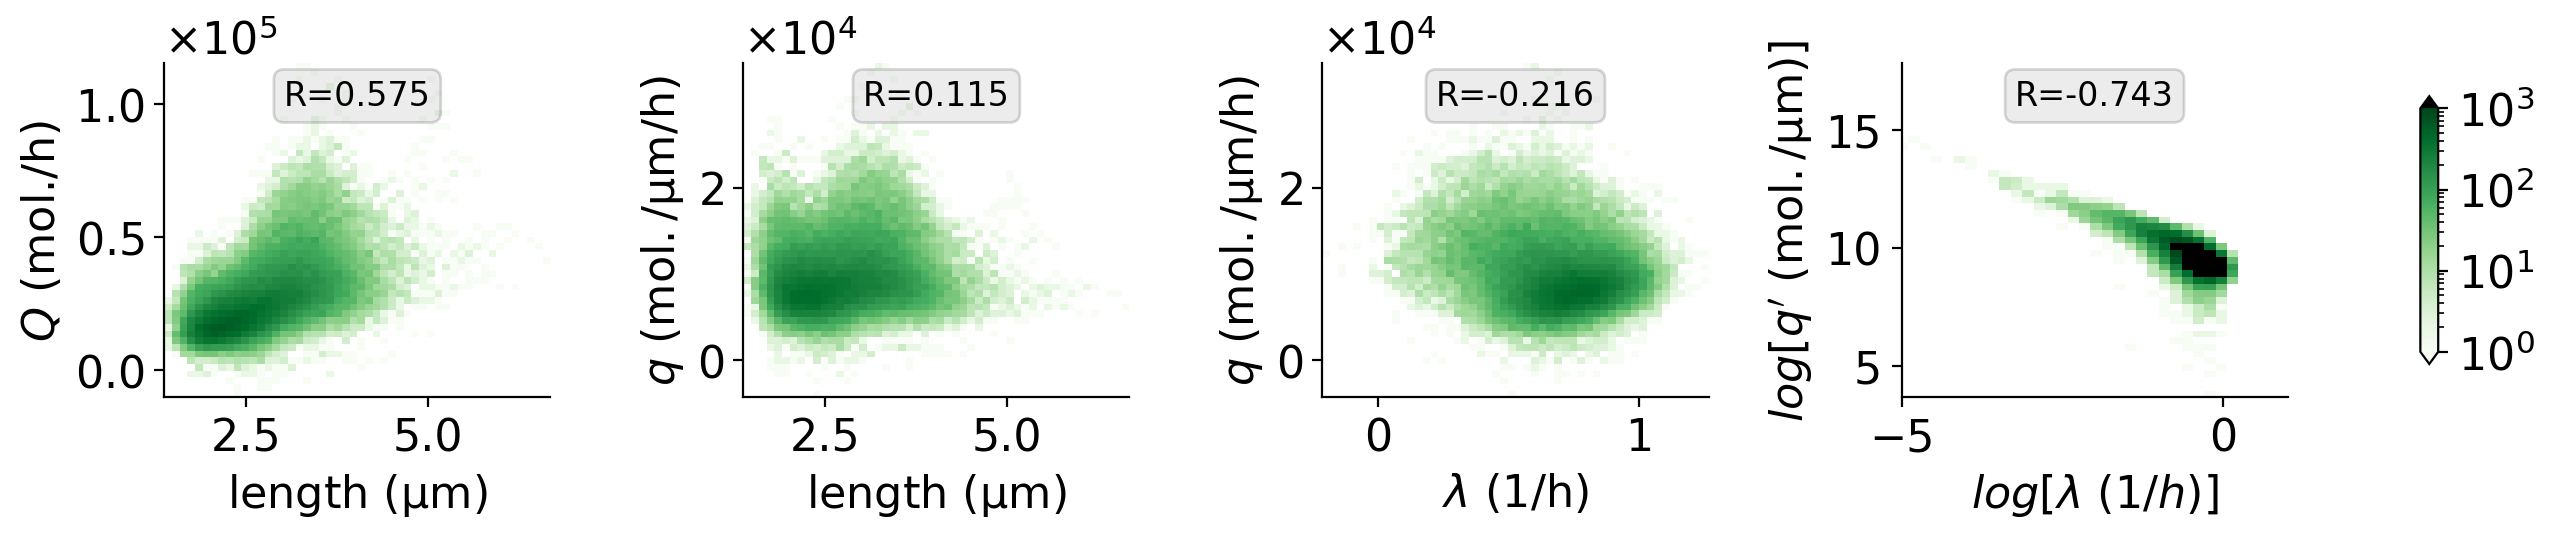

In [6]:
def growth_vs_q_2dhist(samples, plot_file=None, title=None):
    fig, axes = plt.subplots(1,4, figsize=(14.5, 3))
    ax = axes.ravel()
    
    for a in ax:
        a.spines["top"].set_visible(False)
        a.spines["right"].set_visible(False)

        a.spines['right'].set_color('none')
        a.yaxis.tick_left()

    # for a in ax[2:3]:
    #     a.set_xscale('log')
    #     a.set_yscale('log')

    a = 0.02
    if title!=None:
        fig.suptitle(title,fontweight='bold', x=0.43)
    for sample in samples:
        color = color_by_both[samples[sample]["promoter"]][samples[sample]["condition"]]
        cells = samples[sample]["cells"]

        cmap = cmap_by_promoter[samples[sample]["promoter"]]
        cmap = mpl.cm.get_cmap(cmap).with_extremes(over='black')
        normalizer = mcolors.LogNorm(1, 1e3)
        im = mpl.cm.ScalarMappable(norm=normalizer)

        props = dict(boxstyle='round', facecolor='grey', alpha=0.15)

        ############################
        ax[0].set_xlabel(r"length ($\mathrm{\mu}$m)")
        ax[0].set_ylabel("$Q$ (mol./h)")
        h = ax[0].hist2d(get_v(cells), get_Q(cells), cmap=cmap, 
                         bins=50, norm=normalizer, 
                         density=False)

        ax[0].text(0.5, 0.95, get_corr_label(get_v(cells), get_Q(cells)), 
                   transform=ax[0].transAxes, fontsize=SMALL_SIZE,
                   verticalalignment='top',horizontalalignment='center', bbox=props)

        ############################
        ax[1].set_xlabel(r"length ($\mathrm{\mu}$m)")
        ax[1].set_ylabel(r"$q$ $\mathrm{(mol./\mu m/h)}$")          
        h = ax[1].hist2d(get_v(cells), get_q(cells), cmap=cmap, 
                         bins=50, norm=normalizer, 
                         density=False)
                         
        # fig.colorbar(h[3], ax=ax[1])
        # ax[1].set_title(label=get_corr_label(get_v(cells), get_q(cells)))
        ax[1].text(0.5, 0.95, get_corr_label(get_v(cells), get_q(cells)), 
                   transform=ax[1].transAxes, fontsize=SMALL_SIZE,
                   verticalalignment='top',horizontalalignment='center', bbox=props)
        

        ############################
        ax[2].set_xlabel(r"$\lambda$ (1/h)")
        ax[2].set_ylabel(r"$q$ $\mathrm{(mol./\mu m/h)}$")          
        h = ax[2].hist2d(get_lambda(cells), get_q(cells), cmap=cmap, 
                         bins=50, norm=normalizer, 
                         density=False)
        ax[2].text(0.5, 0.95, get_corr_label(get_lambda(cells), get_q(cells)), 
                   transform=ax[2].transAxes, fontsize=SMALL_SIZE,
                   verticalalignment='top', horizontalalignment='center', bbox=props)
        
        ############################
        ax[3].set_xlabel(r"$log[\lambda\  (1/h)]$")
        ax[3].set_ylabel(r"$log[q^\prime\ \mathrm{(mol./\mu m)}]$")
        ll, qp = get_finite_tuple(cells)
        h = ax[3].hist2d(ll, qp, cmap=cmap, 
                         bins=50, norm=normalizer, 
                         density=False)
        # fig.colorbar(h[3], ax=ax[2])
        ax[3].text(0.5, 0.95, get_corr_label(ll,qp), 
                   transform=ax[3].transAxes, fontsize=SMALL_SIZE,
                   verticalalignment='top', horizontalalignment='center',bbox=props)
    
    ax[0].ticklabel_format(axis='y', style='scientific', scilimits=[-2,2], useMathText=True)
    ax[1].ticklabel_format(axis='y', style='scientific', scilimits=[-2,2], useMathText=True)
    ax[2].ticklabel_format(axis='y', style='scientific', scilimits=[-2,2], useMathText=True)
    
    
    # fig.suptitle(label_by_condition[samples[sample]["condition"]] + " " + samples[sample]["promoter"])

    plt.tight_layout()
    plt.subplots_adjust(wspace=0.5)
    
    ax[3].set_xlim(-5,1)

    fig.colorbar(h[3], ax=axes.ravel().tolist(), shrink=0.8, aspect=15, extend='both')


    if plot_file != None:
        fig.savefig(plot_file, bbox_inches='tight')
    plt.show()
    plt.close()


# for c in conditions:
#     for p in promoters:
#         growth_vs_q_2dhist(filter_dict(filter_dict(samples, c),p), None)
#                         #    plot_file="../../figures_for_fluctuations_paper/glucose_hi1_parametrization.pdf")
#     # growth_vs_q_scatter(glu)
#     break

# print(filter_dict(filter_dict(samples, 'glucose020'),'hi1'))
growth_vs_q_2dhist(filter_dict(filter_dict(samples, 'glucose020'),'hi1'), 
                    plot_file="../../figures_for_fluctuations_paper/glucose_hi1_parametrization.pdf")

